In [95]:
import scipy.io
import mne
import os
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
mne.set_log_level('error')


In [36]:
data_root = 'C:/Data/UHD_EEG/'
subjects = ['S1', 'S2', 'S3', 'S4', 'S5']
dominant_hand = ['left','right','right','right','right']

mapping = {0: "No instruction", 1: "Rest", 2: "thumb", 3: "index", 4: "middle", 5: "ring", 6: "little"}

In [3]:
def get_montage(hemishpere):
    mat = scipy.io.loadmat(os.path.join(data_root, 'montage', f'montage_256_{hemishpere}_hemisphere.mat'))
    return mat['pos_256']

left_handed_montage = get_montage('right')
right_handed_montage = get_montage('left')

In [62]:
def load(subject_id, run, describe = True):
    # LOAD DATA
    subject = subjects[subject_id]
    mat = scipy.io.loadmat(os.path.join(data_root, 'rawdata', subject, subject + '_run' + str(run) + '.mat'))
    data = mat['y']
    data = data[1:] # remove timestamp
    ch_names = ['c' + str(i) for i in range(1, 257)]
    ch_names.append('STIM')
    info = mne.create_info(ch_names = ch_names, sfreq=mat['SR\x00'][0][0]) #, ch_types='eeg')
    raw = mne.io.RawArray(data, info)

    # SET CHANNEL TYPES
    for ch in info.ch_names:
        if ch != 'STIM':
            raw.set_channel_types({ch: 'eeg'})
        else:
            raw.set_channel_types({ch: 'stim'})

    events = mne.find_events(raw, stim_channel='STIM')
    annot_from_events = mne.annotations_from_events(events, event_desc=mapping, sfreq=raw.info['sfreq'])
    raw.set_annotations(annot_from_events)
    raw.drop_channels(['STIM'])

    # SET MONTAGE
    if dominant_hand[subject_id] == 'left':
        montage = left_handed_montage
    else:
        montage = right_handed_montage

    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, montage)), coord_frame='head')
    raw.set_montage(montage)

    if describe:
        raw.describe()
    return raw

In [63]:
demo = load(0, 2, False)

In [64]:
demo = demo.resample(200)

In [65]:
demo = demo.notch_filter(50)

In [74]:
mu = demo.filter(8, 12, fir_design='firwin')
beta = demo.filter(13, 25, fir_design='firwin')

c:\Users\Nemes\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


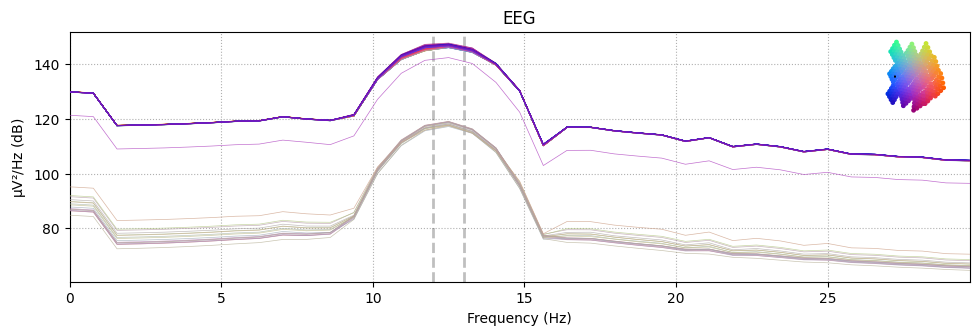

In [59]:
mu.plot_psd(fmax = 30);
plt.show();

c:\Users\Nemes\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


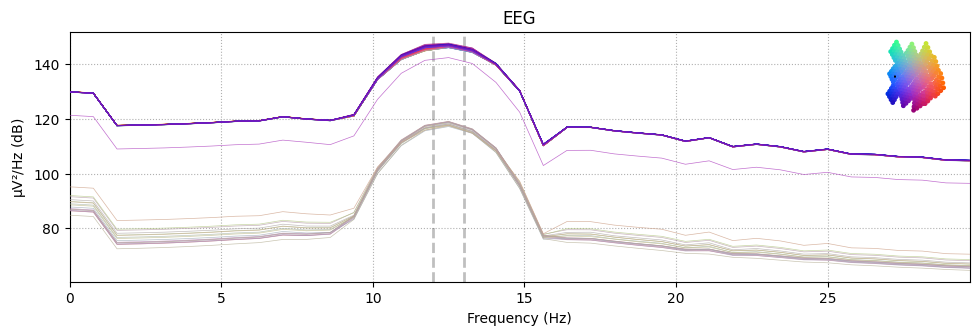

In [60]:
beta.plot_psd(fmax = 30);
plt.show();

In [82]:
epochs = mne.Epochs(mu, mne.events_from_annotations(mu)[0], tmin=-0.5, tmax=1.5, baseline=(-0.5, 0), preload=True)



In [93]:
X = epochs.get_data()
X = X.reshape(X.shape[0], -1)
y = epochs.events[:, -1]

print(X.shape)
print(y.shape)

(26, 102656)
(26,)


In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=82)

In [108]:
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.0

In [109]:
clf.score(X_train, y_train)

1.0